## Import Libraries

In [1]:
import sys
sys.path.insert(1, '../scripts')
import extended_model
import analysis_helper
import importlib
import glob
import json
importlib.reload(extended_model)
importlib.reload(analysis_helper)

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

import numpy as np
import bisect
import itertools

from functools import reduce
from operator import mul
from scipy.stats import norm
import random
from math import comb

import multiprocessing as mp

from tqdm import tqdm
from distinctipy import get_colors
from sklearn.cluster import DBSCAN

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 14

## 4 Beliefs

In [37]:
pool = mp.Pool(processes=32)

folder = 'increased_node_count'
simulation_count = 100
n_nodes = 4
N = 300
p = .2
params = [*zip([*range(simulation_count)], [n_nodes]*simulation_count, [N]*simulation_count, [p]*simulation_count)]

results = pool.starmap(extended_model.simulate_rewiring, params)
graphs = [r[1] for r in results]
results = {sim_no:track for sim_no,track in [r[0] for r in results]}

  5%|▌         | 22920/432001 [00:10<03:13, 2116.77it/s]

  8%|▊         | 33840/432001 [00:15<02:57, 2246.40it/s]


## Analysis of One Simulation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


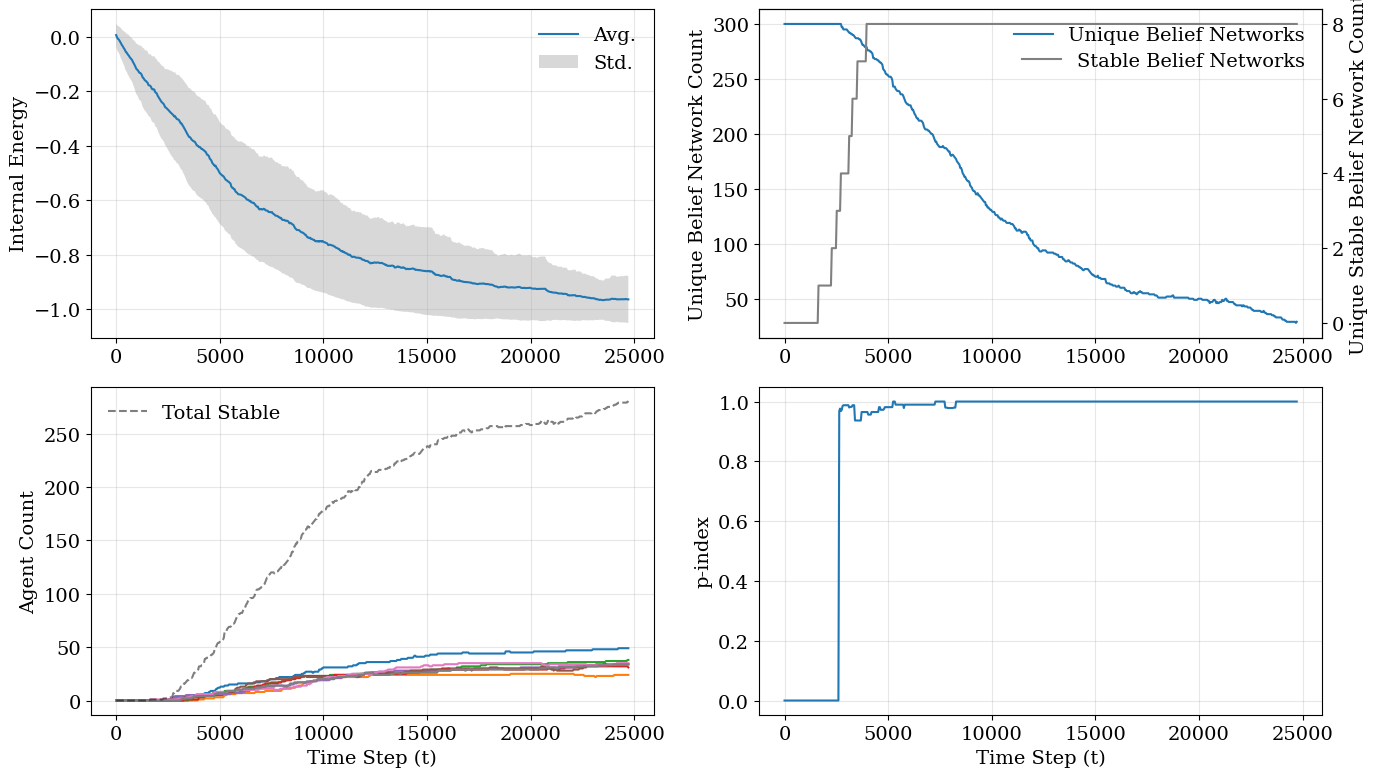

In [45]:
i = 30
track = results[i]
analysis_helper.overall_analysis(n_nodes, track, folder=folder, i=i, save=False)

#### Visualization of the network for the paper

In [18]:
G = graphs[i]
pos = nx.spring_layout(G=G, seed=89)

In [19]:
# p-index
beliefs = [v['beliefs'] for v in track.values()]

from sklearn.cluster import DBSCAN
clustering = [DBSCAN(eps=.1, min_samples=3).fit(b).labels_ for b in beliefs]

polarization_analysis = []

for _, arr in enumerate(beliefs):
    cluster_centroids, polarization = analysis_helper.compute_polarization(clustering = clustering[_], belief_arr = arr)
    polarization_analysis.append(polarization)

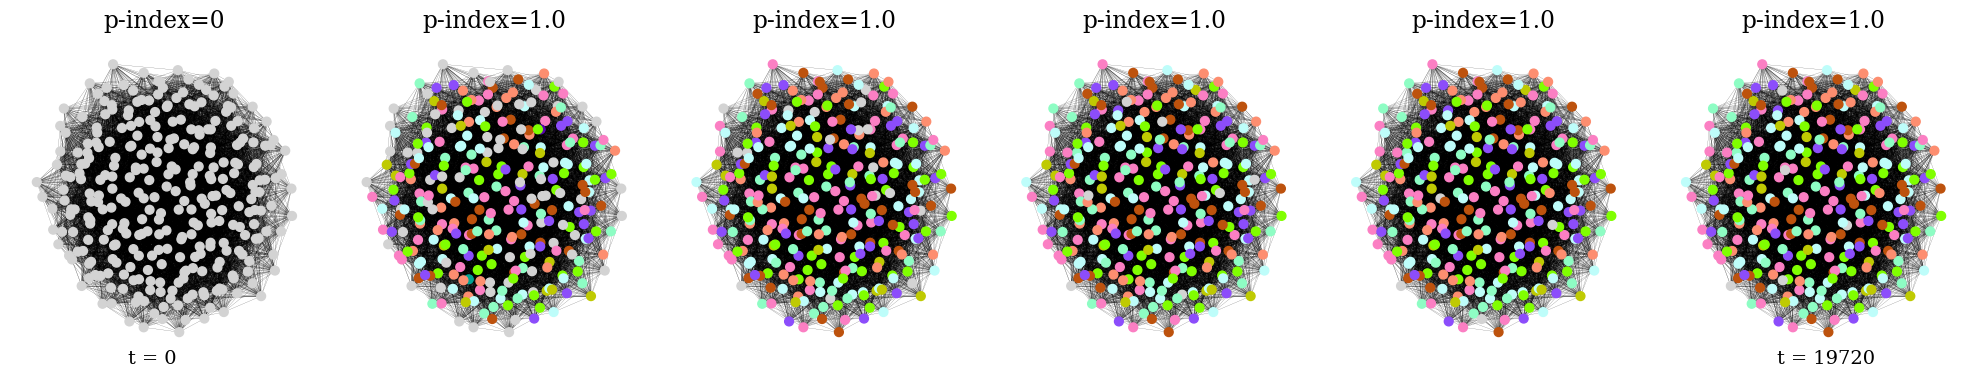

In [40]:
fig, axs = plt.subplots(1,6, figsize=(20,4))

for col,index,t in zip([0,1,2,3,4,5], [0,45,90,135,180,224], [0, 14400, 28800, 43200, 57600, 71680]):
    nx.draw(G, 
            pos, 
            node_size = 40,
            width=.1,
            node_color = ['lightgray' if c['color']=='gray' else c['color'] for c in track[t]['node_coloring'].values()],
            ax=axs[col])
    axs[col].set_title(f'p-index={round(polarization_analysis[index],3)}')

axs[0].text(-.3,-1.2,s='t = 0')
axs[5].text(-.3,-1.2,s='t = 19720')
fig.tight_layout()
fig.savefig(f'../figures/main/{folder}/simulation_{i}_graph_over_t.pdf')

## Summary of All Simulations

In [38]:
internal_energy_analysis_data_sum = extended_model.internal_energy_analysis(results)
polarization_analysis_data_sum = extended_model.polarization_analysis(results)
stability_analysis_data_sum = extended_model.stability_analysis(results, n_nodes = n_nodes)
unique_belief_count_analysis_sum = extended_model.unique_belief_count_analysis(results)
unique_stable_network_count_sum = extended_model.unique_stable_network_count_analysis(results, n_nodes = n_nodes)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


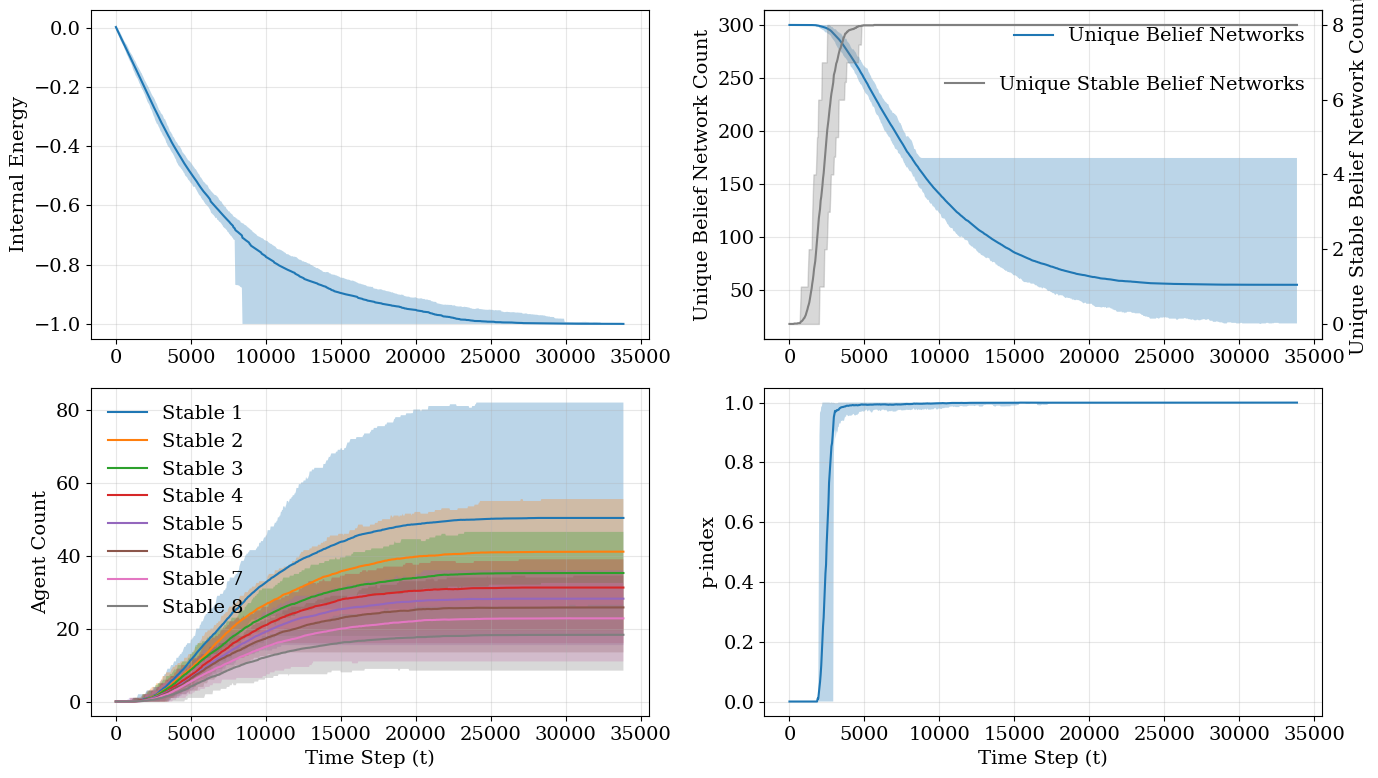

In [39]:
fig, axs = plt.subplots(2,2,figsize=(14,8))

# helpers
types_of_stable = extended_model.permute_stable_networks(n_nodes=4)
max_T = len(internal_energy_analysis_data_sum['avg'])
x = [i* 5 * len(types_of_stable) for i in range(max_T)]

for row, col, d, l in zip([0,0,1,1,1,1,1,1,1,1,1],
                        [0,1,0,0,0,0,0,0,0,0,1],
                        [internal_energy_analysis_data_sum, 
                        unique_belief_count_analysis_sum,
                        stability_analysis_data_sum[0], stability_analysis_data_sum[1], stability_analysis_data_sum[2], stability_analysis_data_sum[3], stability_analysis_data_sum[4], stability_analysis_data_sum[5], stability_analysis_data_sum[6], stability_analysis_data_sum[7],
                        polarization_analysis_data_sum],
                        ['','Unique Belief Networks' ,'Stable 1','Stable 2','Stable 3','Stable 4','Stable 5','Stable 6','Stable 7','Stable 8','']):

    #x = d['x']#[i*20 for i in d['x']] if (l != 'Unique Belief Networks') else d['x']

    axs[row][col].plot(x, d['avg'], label=l)
    axs[row][col].fill_between(x, d['lower'], d['upper'], alpha=.3)

for row,col,l in zip([0,0,1,1],[0,1,0,1], ['Internal Energy', 'Unique Belief Network Count', 'Agent Count', 'p-index']):
    axs[row][col].grid(alpha=.3)
    axs[row][col].set_ylabel(l)
    
    axs[row][col].legend(frameon=False)

axs[1][1].set_ylim(-0.05, 1.05)

axs[1][1].set_xlabel('Time Step (t)')
axs[1][0].set_xlabel('Time Step (t)')

loc = plticker.MultipleLocator(base=1.0)

axs2 = axs[0][1].twinx()
axs2.plot(x,
        unique_stable_network_count_sum['avg'],
        color='gray',
        label='Unique Stable Belief Networks'
        )

axs2.fill_between(x, 
                unique_stable_network_count_sum['lower'],
                unique_stable_network_count_sum['upper'], 
                alpha=.3, 
                color='gray',
                )

axs2.set_ylabel('Unique Stable Belief Network Countx ')
axs2.legend(frameon=False, bbox_to_anchor=(0., .75, 1., .102))

fig.tight_layout()
fig.savefig(f'../figures/main/{folder}/all_simulations_enlarged_beliefs_{n_nodes}.pdf')
fig.show()

## Aggregated Analysis for 4,5,6 Nodes

In [4]:
pool = mp.Pool(processes=32)

folder = 'increased_node_count'
simulation_count = 100
N = 300
p = .2

agg_analysis = {}

for n_nodes in [4,5,6]:
    agg_analysis[n_nodes] = {}

    params = [*zip([*range(simulation_count)], [n_nodes]*simulation_count, [N]*simulation_count, [p]*simulation_count)]
    
    results = pool.starmap(extended_model.simulate_rewiring, params)
    results = {sim_no:track for sim_no,track in [r[0] for r in results]}

    internal_energy_analysis_data_sum = extended_model.internal_energy_analysis(results)
    polarization_analysis_data_sum = extended_model.polarization_analysis(results)
    unique_stable_network_count_sum = extended_model.unique_stable_network_count_analysis(results, n_nodes = n_nodes)

    # flush the RAM
    del results

    agg_analysis[n_nodes]['internal_energy_analysis_data_sum'] = internal_energy_analysis_data_sum
    agg_analysis[n_nodes]['polarization_analysis_data_sum'] = polarization_analysis_data_sum
    agg_analysis[n_nodes]['unique_stable_network_count_sum'] = unique_stable_network_count_sum

  2%|▏         | 43440/2400001 [00:19<17:34, 2235.43it/s]

  1%|▏         | 35520/2400001 [00:16<17:53, 2202.49it/s]

  1%|          | 70400/10800001 [00:29<1:16:06, 2349.38it/s]


In [20]:
res['internal_energy_analysis_data_sum']['x']

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [52]:
res.keys()

dict_keys(['internal_energy_analysis_data_sum', 'polarization_analysis_data_sum', 'unique_stable_network_count_sum'])

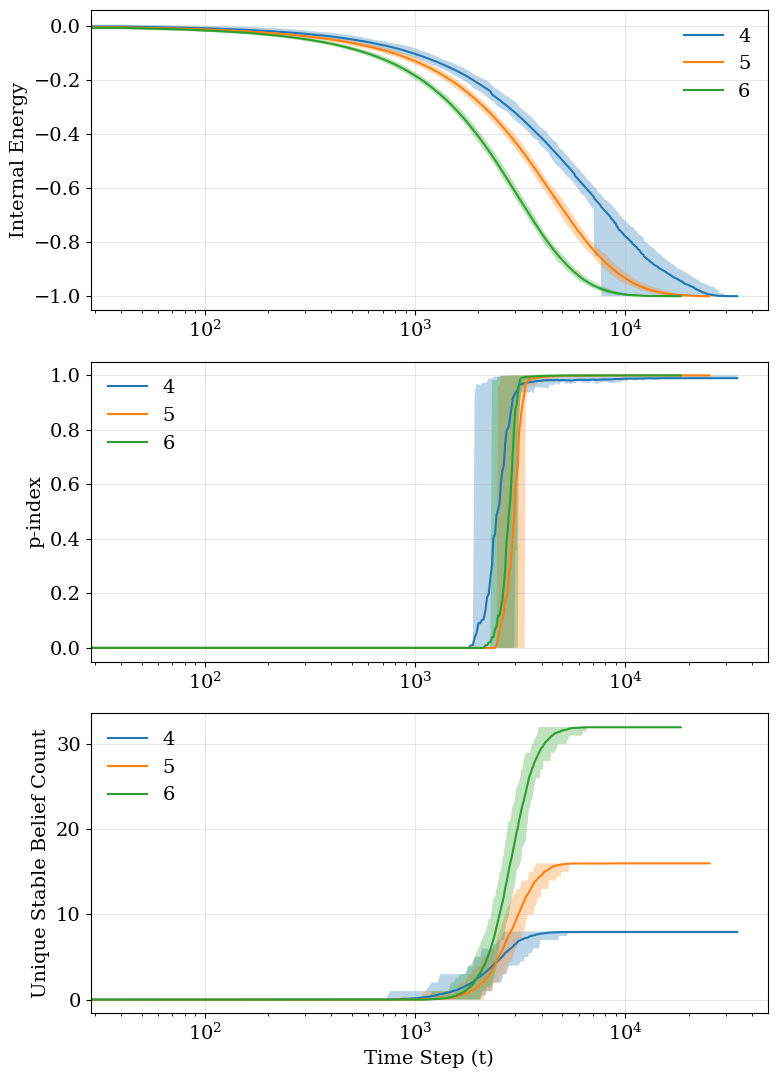

In [62]:
fig,axs = plt.subplots(3,1,figsize=(8,11))

for n_nodes, res in agg_analysis.items():
    x = np.array(res['polarization_analysis_data_sum']['x'])/20*5*8
    for row, analysis in enumerate(res.values()):
        axs[row].plot(x, analysis['avg'], label = n_nodes)
        axs[row].fill_between(x, analysis['lower'], analysis['upper'], alpha=.3)

for row, xlabel in zip([0,1,2], ['Internal Energy', 'p-index', 'Unique Stable Belief Count']):
    axs[row].grid(alpha=.3)
    axs[row].legend(frameon=False)
    axs[row].set_ylabel(xlabel)
    axs[row].set_xscale('log')

axs[row].set_xlabel('Time Step (t)')

fig.tight_layout()